# Lab 3. Variational algorithms

<div class="alert alert-block alert-success">

**Readme**  
    
There are 15 exercises (marked in Green) in total in this Jupyter notebook. These questions will teach you on

Part 1. Simulating Quantum Circuit (Exercises 1-7)

Part 2. Extracting Observable from Measurement (Exercises 8-9)

Part 3. Building Variational Quantum Eigensolvers from Scratch to Solve the Maxcut Problem (Exercises 10-15)
    
The exercises are very straightforward, with solutions in one or two lines. Feel free to ask your mentors and discss with your classmates.
    
At the end of the exercises, there is an **Open Challenge**, where you can try to work out a solution as much as you can. Submit your Jupyter Notebook to qian.wenyang@usc.es by Friday midnight to compete for a winner prize sponsored by IBM Quantum.
    
</div>

In [ ]:
# make sure these libraries are install
# if not, use pip install to install them

# !pip install matplotlib
# !pip install pylatexenc
# !pip install qiskit
# !pip install qiskit-aer
# !pip install qiskit_algorithms
# !pip install numpy
# !pip install networkx

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import execute, Aer, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.tools.visualization import plot_histogram
from qiskit.primitives import Estimator, Sampler
import qiskit_aer
import qiskit_algorithms
import qiskit.tools.jupyter

%qiskit_version_table

## Part 1. Simulating Quantum Circuit

In this part, you will learn the basic tools to simulate quantum circuit for some time evolution operator $\exp(-iHt)$.

<div class="alert alert-block alert-success">

**Exercise 1. Building Pauli Operator**  
    
Following the first example below, build Pauli Y, Z, I operators similarly using *SparsePauliOp* class.
    
You can read more about *SparsePauliOp* class [here](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html)
</div>

In [ ]:
X = SparsePauliOp('X')
##### ==================================
# Write your solution in here.
Y = 
Z = 
I = 
##### ==================================

print("Pauli-X operator:")
print(X.to_matrix())
print("\nPauli-Y operator:")
print(Y.to_matrix())
print("\nPauli-Z operator:")
print(Z.to_matrix())
print("\nPauli-I operator:")
print(I.to_matrix())

Make sure you check these single-qubit Pauli operators in matrix form and it should agree with your expectation.

Here are the major Pauli arithmetic operations you need to construct more interesting Pauli operators.

(a) **Multiple-qubit Pauli Operators**. You need represent tensor product of Paulis with $^$ symbol. See the examples below.

Example 1: 4-qubit tensor product, $I \otimes X\otimes Y \otimes Z$

In [3]:
I^X^Y^Z

SparsePauliOp(['IXYZ'],
              coeffs=[1.+0.j])

Note, Qiskit used a reversed notation, so it is actually $I_3 \otimes X_2\otimes Y_1 \otimes Z_0$

(b) **Scalar Product**. You will need to use the $*$ symbol between the coefficient and the Pauli.

Example 2: 4-qubit tensor product, $4 I \otimes X\otimes Y \otimes Z$

In [4]:
4*I^X^Y^Z

SparsePauliOp(['IXYZ'],
              coeffs=[4.+0.j])

(c) **Linear Combinations of Pauli Operators**. You will use the $+$ symbol to write a linear combination of the Pauli operators. Only Pauli operators of the same number of qubits can be joined. Grouping into parenthesis indicate different components.

Example 3: 4-qubit linear combinations, $X\otimes X\otimes I \otimes I + 2I \otimes Y\otimes  Y\otimes I + 3I \otimes I\otimes  Z\otimes Z$

In [5]:
(X^X^I^I) + 2*(I^Y^Y^I) + 3*(I^I^Z^Z)

SparsePauliOp(['XXII', 'IYYI', 'IIZZ'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

(d) **Product of Pauli Operators**. *SparsePauliOp* class really shines when you want to compute qubitwise product of pauli operators. You will use the $@$ symbol. 

In the example below, you can see it supports algebraic expression and knows Pauli matrix properties. The final result can be further simplified with *.simplify()* method. 

In [6]:
# contructing an interesting Pauli operator

op1 = X^Y
op2 = Y^X

res = op1@op1 + op2@op2 + op1@op2 + op2@op1

print(res)

SparsePauliOp(['II', 'II', 'ZZ', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [7]:
print('\nSum of product after .simplify()')
print(res.simplify())


Sum of product after .simplify()
SparsePauliOp(['II', 'ZZ'],
              coeffs=[2.+0.j, 2.+0.j])


<div class="alert alert-block alert-success">

**Exercise 2. Building Multi-qubit Pauli Operator**  
    
Build Pauli Operator $$H_{sw} = \frac{1}{2}(I_0I_1+X_0X_1 + Y_0Y_1+ Z_0Z_1)$$ using your X, Y, Z, I variables defined above. Or you can use *SparsePauliOp* directly from the list of Paulis.
</div>

In [ ]:
##### ==================================
# Write your solution in here.
H_sw = 
##### ==================================

print(H_sw)

Great, now you have build an important quantum operator. You will see in a few more steps.

In class, we learned how to simulate any Pauli-based exponential $\exp(-iHt)$. Let us briefly recall,

* Simplify $H$ into disjoint, commuting Pauli terms.
* Ultilize different Trotter formulas, such as Lie-Trotter to linear order, to approximate the expression.
* Build towers of Rz (Rotation Z gate) and CX (Control-Not gate) for purely Pauli-Z based operator
* Prepend and Append H, or SH gates for Pauli-X and Pauli-Y based operators.
* The coefficients naturally appear in the Rz rotation angle.

In general it is very complicated. Luckily, with Qiskit, you do not worry about it. All these can be easily constructed using *PauliEvolutionGate* class. (there are also many more classes)

See an example below, to construct a two-qubit $\exp\big[-i (XY) t\big]$ for t = 1.5 seconds.

In [9]:
peg = PauliEvolutionGate(operator=(X^Y), time=1.5)
peg

Instruction(name='PauliEvolution', num_qubits=2, num_clbits=0, params=[1.5])

Note *PauliEvolutionGate* is essentially quantum circuit instructions. To build it into a Qiskit quantum circuit, you will need to append these instruction to some quantum circuits, for example below

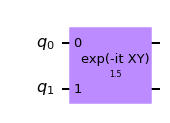

In [10]:
qc = QuantumCircuit(2) # our main circuit
qc.append(peg, [0, 1]) 
# [0, 1] indicates the location of the appending operation. 
# Here, it is qubit-0 to qubit-0 and qubit-1 to qubit-1
# as you can see in the circuit, 0 is connected to 0, 1 is connected to 1
qc.draw(output='mpl')

<div class="alert alert-block alert-success">

**Exercise 3. Building Quantum Circuit to Simulate Exponential of Operator**  
    
Build quantum circuit of $\exp(-i H_{sw} t)$ of your previous Hamiltonian $H_{sw}$ using *PauliEvolutionGate* class. Write a generic function that involves an input operator and an input time.
</div>

In [ ]:
def time_evolve(operator, time):
    ##### ==================================
    # Write your solution in here.    
    
    
    
    ##### ==================================
    return qc

# Test your circuit
qc_ex = time_evolve(H_sw, 1.5)
qc_ex.decompose().draw(output='mpl')

You should see 4 Pauli exponential blocks here. Why? Because all these Pauli terms are commutative. So, we can simulate them blockwise and without error!

But then you may ask, how do we verify them individually and see the tower structure of CX gates and RZ gates we saw in class?

There are more than one ways to decompose the quantum circuit. To see what we saw in class, we need to transpile the quantum circuits to the basis gates that we are assigning them.

Introducing the *transpile* function, which takes a quantum circuit and a list of basis gates. Run the command below and verify with your expectation.

<div class="alert alert-block alert-success">

**Exercise 4. Transpiling Quantum Circuit to Specified Gate Sets**  
    
Transpile your quantum circuit to basis gates "h", "s", "sdg", "rz", "cx". Does it match your expectation?
</div>

In [ ]:
qc_ex = time_evolve(H_sw, 1.5)

transpiled_qc = transpile(qc_ex, basis_gates=['h', 's', 'sdg', 'rz', 'cx'])
transpiled_qc.draw(output='mpl')

Note, you should try to identify **three** towers of Rz gates with CXs. 

The $\exp(-iIIt)=\cos(t) II - i \sin(t) II = \Big(cos(t)-i\sin(t)\Big) II$ becomes part of the global phase, because  so Qiskit automatically skipped its simulation.

<div class="alert alert-block alert-success">

**Exercise 5. Building Complete Quantum Circuit with Initialization and Measurement**  
    
Before simulating your quantum circuit, we need to add an initialization block and a measurement block.
    
To make things interesting, try initialize qubit-0 as $|1\rangle$, qubit-1 as $|0\rangle$ state, and then time evolve your $H_{sw}$ for $\pi/2$ period, and finally add a measurement block.

Now we have a complete circuit!
    
</div>

In [ ]:
qc_ex = QuantumCircuit(2)
##### ==================================
# Write your solution in here.
# 1. Initialize qubit_0 as |1>, qubit_1 as |0> state


# 2. Time evolve for t = pi/2, using your function *time_evolve* 


# 3. Measure all


##### ==================================
qc_ex.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

**Exercise 6. Simulate with Ideal Shot-based Simulator (part 1)**  
    
Let us simulate your quantum circuit with the ideal shot-based simulator.

There are many ways to do it in Qiskit, I wrote two popular functions to do it for you

- Using *execute* method
- Using *Sampler* class (working for new Qiskit versions)
    
Try to run different number of shots, 10, 100, 100, 1000. What do you observe?
</div>

In [14]:
# sv_sim = Aer.get_backend('statevector_simulator')
# qasm_sim = Aer.get_backend('qasm_simulator')

def sample_with_shots(circuit, shots, normalize=True):
    ''' Old-fashioned approach, previous versions of Qiskit, should work for everyone '''
    qasm_backend = Aer.get_backend('qasm_simulator')
    dist = execute(circuit, qasm_backend, shots=shots).result().get_counts()
    if normalize:
        norm = sum(dist.values())
        dist = {k: v/norm for k, v in dist.items()}
    return dist
    
def sample_with_shots_v2(circuit, shots):
    ''' Using Sampler class, based on Latest version of Qiskit (v0.44) '''
    shot_sampler = Sampler(options={"shots": shots})
    dist = shot_sampler.run(circuit).result().quasi_dists[0]
    return dist

In [ ]:
##### ==================================
# Write your solution in here.
# Try write each one with the type of sample function
dist_10    = 
dist_100   = 
dist_1000  = 
dist_10000 = 
##### ==================================

dist_list = [dist_10, dist_100, dist_1000, dist_10000]

plot_histogram(dist_list, legend=["10 shots", "100 shots", "1000 shots", "10000 shots"])

Since we started with $|q_1q_0\rangle = |01\rangle$ state, you will see the result in **any shot** is now a $|10\rangle$ state. 

Yes, that is right. You have just implemented a SWAP gate. There are many implementations of SWAP gates. Here, you simulate a SWAP gate by $\exp(-i\frac{(II+XX+YY+ZZ)}{2}\theta)$ with an angle $\theta=\pi/2$, which your simulation time here.

Now, what will happen if you try to rotate only half the angle? What do you think will happen.


<div class="alert alert-block alert-success">

**Exercise 7. Simulate with Ideal Shot-based Simulator (part 2)**  
    
Now try change the evolution time to $\pi/4$. What do you see?
    
Try to run different number of shots, 10, 100, 100, 1000. What do you observe?
</div>

In [ ]:
qc_ex = QuantumCircuit(2)
##### ==================================
# Write your solution in here.
# 1. Initialize qubit_0 as |1>, qubit_1 as |0> state


# 2. Time evolve for t = pi/4



# 3. Measure all


##### ==================================

dist_10 = sample_with_shots(qc_ex, 10)
dist_100 = sample_with_shots(qc_ex, 100)
dist_1000 = sample_with_shots(qc_ex, 1000)
dist_10000 = sample_with_shots(qc_ex, 10000)

dist_list = [dist_10, dist_100, dist_1000, dist_10000]

plot_histogram(dist_list, legend=["10 shots", "100 shots", "1000 shots", "10000 shots"])

It should be an even superposition of $|01\rangle$ and $|10\rangle$ states right? With the number of shots going larger and larger, the probability distributions should be 0.5 for each.

In practice, this is very important property, with different angles, you can generate desire weighted sum of these one-hot encoded bitstrings, which has many applications especially in quantum machine learning and combinatorial problems.

Now that, we have talked about simulating any Hamiltonian. We will switch to discussing extracting observables from the quantum circuit. 

## Part 2. Extracting Observables

<div class="alert alert-block alert-success">

**Exercise 8. Building Pauli Observables**  
    
Building Pauli observables is the same as constructing Pauli operators. Try build a Pauli operator 
$$ O_{ex} = \frac{1}{2}\Big((I-Z)\otimes I - I\otimes (I-Z)\Big) $$
    
After you finish, predict what you get if measuring this observable for the distribution above?
    
Remember $\frac{(I-Z)}{2}|0\rangle = 0|0\rangle=0$ and $\frac{(I-Z)}{2}|1\rangle = 1|1\rangle$
</div>

In [ ]:
##### ==================================
# Write your solution in here.
O_ex = 

##### ==================================
O_ex

<div class="alert alert-block alert-success">

**Exercise 9. Extracting Observables**  
    
Extracting observables on the quantum circuit is very easy thanks to *Estimator* class. It is very similar to *Sampler* class. I have written this function *estimate_with_shots* for you.
    
Use the function below to test the observable you get with the different shots assigned to you.

</div>

In [ ]:
def estimate_with_shots(circuit, observable, shots):
    ''' Using Sampler class '''
    _circuit = circuit.copy()
    _circuit.remove_final_measurements()
    shot_estimator = Estimator(options={"shots": shots})
    expectation = shot_estimator.run(_circuit, observable).result().values[0]
    return expectation

shot_list = np.round(np.geomspace(10, 10000, 30))
expectation_list = []

##### ==================================
for shots in shot_list:
# Write your solution in here.



##### ==================================


plt.scatter(shot_list, expectation_list)
plt.ylabel(r'$\langle O_{ex}\rangle$', fontsize=20)
plt.xlabel('shots', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hlines(0, 0, 10000, ls='dashed')
plt.show()

You should observe that the expectation value approaches 0 as the number of shots increase. It is because, our observable is basically a number operator (or counting operator if you like). 

It counts the number of 1's in each qubit and subtract them. From the distribution earlier, you should expect zero, since we have an even distribution of $|01\rangle$ and $|10\rangle$.

You should also see that having enough shots is crucial to simulation results. On the other hand, having too many shots will not help the simulation after certain point. It is essentially closely related the state space of the many-qubit systems.

## Part 3. Maxcut Problem

### Given a graph of n nodes, how do we cut the graph into two partitions such that the number of edges between the two partitions are maximized?

In a nutshell, Maxcut = Maximum cut

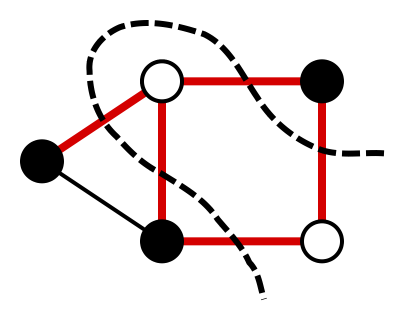

This is the so-called Maxcut problem, which is an NP-hard problem in general. It has excited many algorithms to calcuate its solution. In general, a bruteforce that enumerate all possible partitions will break down at large graph limit. So people have dived into approximation algorithms to solve this combinatorial problem. It has become an important subfield in Discrete Mathematics.

With the advent of quantum computing, Maxcut has been applied extensively using variational quantum algorithms and for some specific subfield of this interesting problem, the quantum approach seems to beat the classical approach. 

Today, we will look at the formulation of an ideal Maxcut problem (i.e., no constraints, no edge weight, etc), and we will use one of the popular quantum simulation techniques, the variational quantum eigensolver, to solve this problem by ourselves.

We start by loading the networkx module and some helper functions...

In [19]:
# make sure networkx is installed, if not you can use Pip to install it, pip install networkx
import networkx as nx

In [20]:
# load helpful functions
def prepare_maxcut(n, edges):
    '''
    n: number of nodes in G
    edges: list of connected edge pairs in G, make sure edges are indexed from 0, 1, to (n-1)
    '''
    for ei, ej in edges:
        assert 0 <= ei < n and 0 <= ej < n, f"Invalid edges! Edge ({ei}, {ej}) is Not allowed in a {n}-node Graph."
    G = nx.Graph()
    G.add_nodes_from(np.arange(0, n, 1))
    G.add_edges_from(edges)
    pos = nx.shell_layout(G)  # fix plot position, more options see 
    return G, pos

def plot_maxcut(G, pos, colors=None):
    '''
    Plot the Maxcut problem instance
    '''
    if colors == None:
        colors = ["lightgray" for node in G.nodes()]
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=1000, alpha=1.0, ax=default_axes, pos=pos)
    nx.draw_networkx_edges(G, pos=pos)
    
def get_adj_matrix(G):
    '''
    Return an adjacency matrix of G, representing w_ij
    '''
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = 1
    return w

def get_bruteforce_sol(G, verbose=False):
    '''
    Return the bruteforce solution for the adjacency matrix of a Maxcut graph.
    '''
    G_adj = get_adj_matrix(G)
    best_cost_brute = 0
    for b in range(2**n):
        # b = 0, x = [0, 0, 0, 0]
        # b = 1, x = [1, 0, 0, 0]
        # b = 2, x = [0, 1, 0, 0] ...
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + G_adj[i, j] * x[i] * (1 - x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
        if verbose: print("case = " + str(x) + " cost = " + str(cost))
    return xbest_brute, best_cost_brute

<div class="alert alert-block alert-success">

**Exercise 10. Familiar with Maxcut problem**  
    
Play with these functions above 
- *prepare_maxcut*
- *plot_maxcut*
- *get_adj_matrix*
- *get_bruteforce_sol*
    
See if you can come up with an interesting Maxcut problem. 
    
Warning, be careful with the number of nodes, n, in the Graph. Your computer might crash if n is too big.

</div>

Adjacency matrix W = 
 [[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


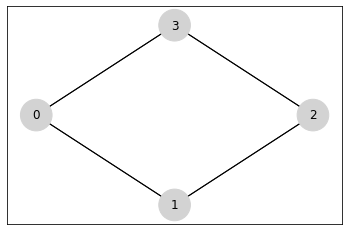

In [21]:
# Example 1.
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)
print("Adjacency matrix W = \n", get_adj_matrix(G))
plot_maxcut(G, pos)

In [ ]:
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=True)
print("\nBest solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Adjacency matrix W = 
 [[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0.]]


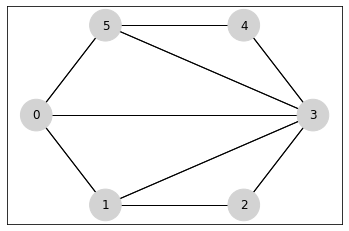

In [23]:
# Example 2.
n = 6
edges = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0], [3, 0], [1, 3], [3, 5]]
G, pos = prepare_maxcut(n, edges)
print("Adjacency matrix W = \n", get_adj_matrix(G))
plot_maxcut(G, pos)

In [ ]:
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=True)
print("\nBest solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

In [ ]:
# Example 3.
n = 8
edges = [[i, i+1] for i in range(0, n-1)] + [[n-1, 0]]
edges += [[0, 2], [1, 3], [2, 4], [3, 7], [2, 6], [3,4], [6,7], [5,7], [0, 4], [0, 6]]
G, pos = prepare_maxcut(n, edges)
xbest_brute, best_cost_brute = get_bruteforce_sol(G)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Did you come up with something more interesting?

<div class="alert alert-block alert-success">

**Exercise 11. Building the Maxcut Hamiltonian**  
    
From the lecture, we know the Maxcut Hamiltonian looks like,
    
$$    H = \sum_{ij} w_{ij}x_i(1-x_j) = \sum_{ij} w_{ij}\frac{I_i-Z_i}{2}\Big(I- \frac{I_j-Z_j}{2}\Big) = \sum_{i} c_{i} Z_i + \sum_{ij} d_{ij} Z_iZ_j$$
    
Use the helper function below (or come up with your own) to build the Hamiltonian for Maxcut.
    
Important to verify, your final, simplied Hamiltonian must only contain Pauli Z expressions.
</div>

In [26]:
# helpful functions
def get_x_op_at_i(i, n):
    ''' Return an operator (I-Z)/2 at specified qubit index i, with n qubits in total '''
    candidates = [I]*n
    candidates[i] = (I - Z)/2
    res = candidates[0]
    for i in range(1, n):
        res = res^candidates[i]
    return res

def get_I_op(n):
    ''' Return an identity operator over n qubits'''
    return SparsePauliOp(["I"*n], [1])

print(get_x_op_at_i(1, 4))
print(get_I_op(4))

SparsePauliOp(['IIII', 'IZII'],
              coeffs=[ 0.5+0.j, -0.5+0.j])
SparsePauliOp(['IIII'],
              coeffs=[1.+0.j])


In [27]:
def get_Hamiltonian_of_graph(G):
    '''
    Get Pauli-ZZ Hamiltonian for the adjacency matrix of a graph
    '''
    G_adj = get_adj_matrix(G)
    n = len(G_adj)
    Hamiltonian = 0

    for i in range(n):
        for j in range(n):
            if G_adj[i][j] != 0: # to speed up, avoid 0
                ##### ==================================
                # Write your solution in here.  
                # basically, you try to add all nonzero pauli terms to the Hamiltonian variable
                # each pauli term is a product of two pauli operator
                

                
                ##### ==================================
                
    Hamiltonian = Hamiltonian.simplify()  # simplify algebraic expression
    return Hamiltonian

In [ ]:
# Verification, Hamiltonian must contain only Pauli-Z
# Try start with a simple graph first, then move to a larger graph.
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)
H = get_Hamiltonian_of_graph(G)
print(H)
plot_maxcut(G, pos)

<div class="alert alert-block alert-success">

**Exercise 12. Vartional Quantum Eigensolver, part 1**  
    
With the Hamiltonian defined, we now write the Vartional Quantum Eigensolver (VQE) from scratch. The VQE optimization loop consists of three essential parts

- Variational ansatz

- Quantum evolution and expectation evaluation, i.e. $\langle H \rangle = \langle \psi | H | \psi \rangle $
    
- Classical optimizer to update the next parameter, or exit the loop.
    
The following exercises help you build the VQE one by one.
    
We first look at the variational ansatz. For this part, we use the so-called Two-Local ansatz (available as *TwoLocal* class from Qiskit), where only adjacent qubit are connected (entangled). It is a commonly-used hardware-efficient ansatz, commonly used in quantum optimization problems.
    
Study carefully the example below and let's write a function to build our ansatz for graph of any node size $n$ and an arbitrary number of layers.
    
</div>

In [29]:
from qiskit.circuit.library import TwoLocal

In [ ]:
# An example on how to build 4-qubit TwoLocal ansatz with "ry" rotation gates, "cz" entanglement gates, and a depth of 5 repeated layers. 
# which is good starting place for us.
ansatz = TwoLocal(4, "ry", "cz", reps=5, entanglement="linear")
ansatz.decompose().draw(output='mpl')

In [ ]:
# build our own function using the example above 
def get_ansatz(n, layers):
    ##### ==================================
    # Write your solution in here.  
    ansatz = 
    
    ##### ==================================
    return ansatz

# test
get_ansatz(6, 3).decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

**Exercise 13. Vartional Quantum Eigensolver, part 2**  
    
We now look at the measuring the observable.
    
We write an *get_expectation* function to take in a variantional ansatz, a list of parameters, an observable, and a shot number. It returns the expectation value. 
    
Try take advantage of our own function *estimate_with_shots* defined earlier.
    
Note, the ansatz qubits and the observable qubits must be the identical.
        
</div>

In [32]:
def get_expectation(ansatz, params, observable, shots):
    assert ansatz.num_qubits == observable.num_qubits, f"ansatz qubits = {ansatz.num_qubits}, observable qubits = {observable.num_qubits}"
    ##### ==================================
    # Write your solution in here.  
    
    
    
    ##### ==================================
    return expectation

In [ ]:
# test
# maxcut problem instance
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)

# building ansatz and observable
ansatz_ex = get_ansatz(n, 3)
parameters = [0.1]*ansatz_ex.num_parameters
observable = get_Hamiltonian_of_graph(G)

# expectation
get_expectation(ansatz_ex, parameters, observable, 1000)

Note, your *get_expectation* function should return a value, which is the expectation value of quantum state generated by the ansatz. By tuning the parameters, you will see that this expectation value is different.

Essentially, the VQE algorithm finds the optimal parameter of the ansatz such that your expectation is minimizes. By the Variational Principle, when the expectation minimizes, our guess wavefunction approaches the ideal wavefunction.

In short, your ansatz with optimal parameters becomes your ideal wavefunction.

<div class="alert alert-block alert-success">

**Exercise 14. Vartional Quantum Eigensolver, part 3**  
    
We now look at the last step, which is the optimization using classical optimizer, to complete our VQE function.
    
Our *vqe_from_scratch* takes a Maxcut problem instance G, a variational ansatz, and number of shots.
    
Specifically, we use Qiskit's *COBYLA* optimizers. Since *COBYLA* only has a *minimize* method, and we try to maximize the expectation observable (because it is called Maxcut!), we should evaluate $-\langle H \rangle$ in the *COBYLA.minimize* method. Maximum iterations, i.e., *maxiter*, should also be supplied.
        
To make results somewhat comparable, we add *random_seed* argument for initializing the parameter. However, simulation itself still involves randomness (a topic for another day).

There are a lot of optimizers you can use if you are interested, available in [qiskit.algorithms.optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). If you are using other classes, call_back functions need modify, see comments within.
</div>

In [34]:
from qiskit_algorithms.optimizers import COBYLA
# from qiskit.algorithms.optimizers import COBYLA # if last line does not work, use this one (but I recommend first line)


def maxcut_vqe_from_scratch(G, ansatz, shots, maxiter=300, random_seed=0, verbose=True):
    '''
    Our VQE from scratch for Maxcut problem G
    
    Return the VQE optimization result and its history
    
    '''
    
    # Helper function
    exp_val_list = []
    def callback(params):
        '''
        Callback to record expectation history and more!
           It is always optimizer dependent, so very tricky in general, for other optimizers, 
           you will need modify the argument to callback(num_eval, param, f_eval, step, acc) instead
        '''
        exp_val = get_expectation(ansatz, params, observable, shots)
        exp_val_list.append(exp_val)
        if verbose == True: print(f"step {len(exp_val_list):>4}:  <H> = {exp_val:>6.3f}")
    
    initial_parameters = [0.1]*ansatz_ex.num_parameters
    observable = get_Hamiltonian_of_graph(G)
    
    def minimize_func(params):
        ##### ==================================
        # Write your solution in here.     

        
        
        
        ##### ==================================
        return value_to_maximize

    np.random.seed(random_seed)
    initial_params = 0.1* np.random.random(ansatz.num_parameters)
    opt = COBYLA(maxiter=maxiter, callback=callback)
    
    res = opt.minimize(minimize_func, initial_params)
    
    return res, exp_val_list

In [ ]:
# test
# maxcut problem instance
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)

# building ansatz and observable
ansatz = get_ansatz(n, 1)

# vqe
opt_res, exp_val_list = maxcut_vqe_from_scratch(G, ansatz, shots=1000)

In [ ]:
def plot_vqe_exp_val_list(exp_val_list, G=None):
    N = len(exp_val_list)
    xs = np.arange(1, N+1)
    plt.scatter(xs, exp_val_list, label='quantum simulation')
    plt.ylabel(r'Maxcut', fontsize=20)
    plt.xlabel('Iteration step', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if G != None:
        xBest, costBest = get_bruteforce_sol(G)
        plt.hlines(costBest, 0, N, ls='dashed', color='red', label='bruteforce')
    plt.legend(fontsize=15)
    plt.show()
    
# visualize result   
plot_vqe_exp_val_list(exp_val_list)

In [ ]:
# visualize with bruteforce
plot_vqe_exp_val_list(exp_val_list, G)

If you see your simulation result agrees with the bruteforce as step increases, that indicates your algorithm is correct!

Big congratulations! You have implemented VQE from scratch, essentially.

<div class="alert alert-block alert-success">

**Exercise 15. Vartional Quantum Eigensolver, part 4**  
    
Hopefully your VQE optimization is working and you obtain the expected result with bruteforce calculation. Congratulations! It is a big step.
    
Now, you may wonder how do I know my optimal solution, i.e., the binary variable $x$? Afterall, we also need to know how to partition the graph, where the maximum cut is reached? 
    
The answer is you just need to sample the quantum state with your final, optimal parameters of the ansatz! Use your *sample_with_shots* or *sample_with_shots_v2* class defined before.
</div>

In [ ]:
# your optimal parameters is in the x method of your opt_res object
opt_res.x

In [39]:
def sample_probability_dist(ansatz, optimization_result, shots):
    ##### ==================================
    # Write your solution in here. 
    
    
    
    ##### ==================================
    return dist

In [40]:
def plot_probability_dist(dist):
    '''
    Convenience class to plot distribution
    '''
    if type(list(dist.keys())[0]) != str: # depend on your sample function
        new_dist = {}
        for k, v in dist.items():
            k = "".join([t for t in reversed(list(bin(k)[2:].zfill(n)))])
            new_dist[k] = v
        dist = new_dist
    
    return plot_histogram(dist)

In [ ]:
dist = sample_probability_dist(ansatz, opt_res, 1024)
print(dist)
plot_probability_dist(dist)

Note both 0101 and 1010 are correct solutions, because it does not matter if you call which one in partition which. It is just a label. So we literally achieved nearly 100 % accuracy!

Now, checking with bruteforce solution : )

In [ ]:
# cross check with bruteforce
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=False)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

<div class="alert alert-block alert-success">

**(Open Challenge) Improve your VQE function to solve the Maxcut Problem**  
    
Play wiht your *maxcut_vqe_from_scratch* on a more complicated Maxcut problem to see how it behaves! At some point, for some graph, the algorithm becomes insufficient, indicating the room for improvement.
    
There are literally a million things you can improve from here. To name a few, optimizer, expectation evaluations, etc. Improve your function *maxcut_vqe_from_scratch* and submit to qian.wenyang@usc.es by midnight today to have a chance winning a prize sponsered a IBM Quantum team.

I hope you enjoyed the short journey of quantum simulation. Feel free to let me know if you have any question.

</div>

In [43]:
# You can use my function to generate a randomly hard maxcut graph
def prepare_random_maxcut(n, connectivity=0.3):
    '''
    Some hard maxcut graph generator, not an ideal one
    '''
    assert 0 <= connectivity < 1, "Connectivity is between 0 and 1"
    edges = []
    for i in range(n):
        for j in range(n):
            if i == j: continue
            e, re = [i, j], [j, i]
            if re in edges: continue # can be optimized with cache
            if np.random.random() < connectivity:
                edges.append(e)
    G, pos = prepare_maxcut(n, edges)
    return G, pos

Best solution = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]  Maxcut cost = 18.0


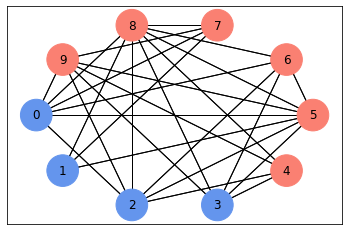

In [44]:
n = 10
G, pos = prepare_random_maxcut(n, 0.3)
xbest_brute, best_cost_brute = get_bruteforce_sol(G)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

In [ ]:
# building ansatz
ansatz = get_ansatz(n, 1)
ansatz.decompose().draw(scale=0.8, output='mpl')

In [ ]:
# vqe optimization
opt_res, exp_val_list = maxcut_vqe_from_scratch(G, ansatz, shots=3000, maxiter=500, random_seed=42,
                                                verbose=False)
plot_vqe_exp_val_list(exp_val_list, G)